In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, silhouette_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
seed = 42
np.random.seed(seed)

In [3]:
train = pd.read_csv('csv_files_harmonized/balanced_train.csv') 
test = pd.read_csv('csv_files_harmonized/test.csv')
val = pd.read_csv('csv_files_harmonized/val.csv')

In [4]:
marker_columns = [col for col in train.columns if col.startswith('CD') or col.startswith('HLA-DR')]

In [ ]:
train[marker_columns] = np.arcsinh(train[marker_columns]/5)
test[marker_columns] = np.arcsinh(test[marker_columns]/5)
val[marker_columns] = np.arcsinh(val[marker_columns]/5)

In [ ]:
train['group'] = train['group'].map({'baseline': 0, 'post': 1, 'healthy': 2})
test['group'] = test['group'].map({'baseline': 0, 'post': 1, 'healthy': 2})
val['group'] = val['group'].map({'baseline': 0, 'post': 1, 'healthy': 2})

In [ ]:
for i in [train, test, val]:
    i['id_split'] = i['id']
    i.loc[i['group'] == 1, 'id_split'] = i.loc[i['group'] == 1, 'id'] + '_post'

In [ ]:
train['id_numeric'], train_id_mapping = pd.factorize(train['id_split'])
test['id_numeric'], test_id_mapping = pd.factorize(test['id_split'])
val['id_numeric'], val_id_mapping = pd.factorize(val['id_split'])

In [ ]:
X_train = train[marker_columns].values
X_test = test[marker_columns].values
X_val = val[marker_columns].values

y_train = train['group'].values
y_test = test['group'].values
y_val = val['group'].values

id_train = train['id_numeric'].values
id_test = test['id_numeric'].values
id_val = val['id_numeric'].values

Doing quick PCA to reduce noise and some dimensionality (10-20 components)

In [ ]:
pca = PCA(n_components=10, random_state=seed)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

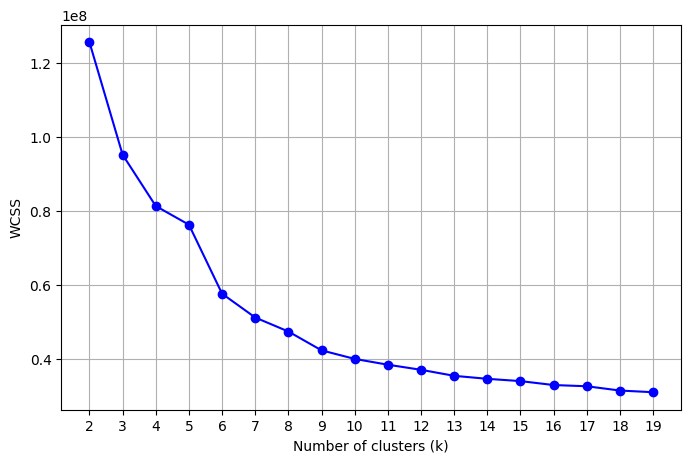

In [ ]:
wcss = []
K_range = range(2, 20) 
for k in K_range:
    km = KMeans(n_clusters=k, random_state=seed)
    km.fit(X_train_pca)
    wcss.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, 'bo-')
plt.xticks(K_range)
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

Ser ut som albuen er på 4 eller 7. (liten en på 10?) (på tsne)
Liten albue på 5 eller 9 for pca? 8?

In [ ]:
silhouette_scores = []
for k in K_range:
    km = KMeans(n_clusters=k, random_state=seed)
    labels = km.fit_predict(X_train_pca)
    score = silhouette_score(X_train_pca, labels, sample_size=10000)
    silhouette_scores.append(score)

plt.plot(K_range, silhouette_scores, 'ro-')
plt.xticks(K_range)
plt.grid(True)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette score')
plt.show()

KeyboardInterrupt: 

10 ser ut som det optimale for tsne
7 ser ut som det optimale for pca

In [ ]:
k = 7

kmeans = KMeans(n_clusters=k, random_state=seed)
train_labels = kmeans.fit_predict(X_train_pca)

In [ ]:
subset_size = 10000
subset_index = np.random.choice(X_train.shape[0], size=subset_size, replace=False)
X_train_subset = X_train_pca[subset_index]
#y_train_subset = y_train[subset_index]
#id_train_subset = id_train[subset_index]
labels_subset = train_labels[subset_index]

In [ ]:
tsne = TSNE(n_components=2, random_state=seed, perplexity=30)
X_train_tsne = tsne.fit_transform(X_train_subset)

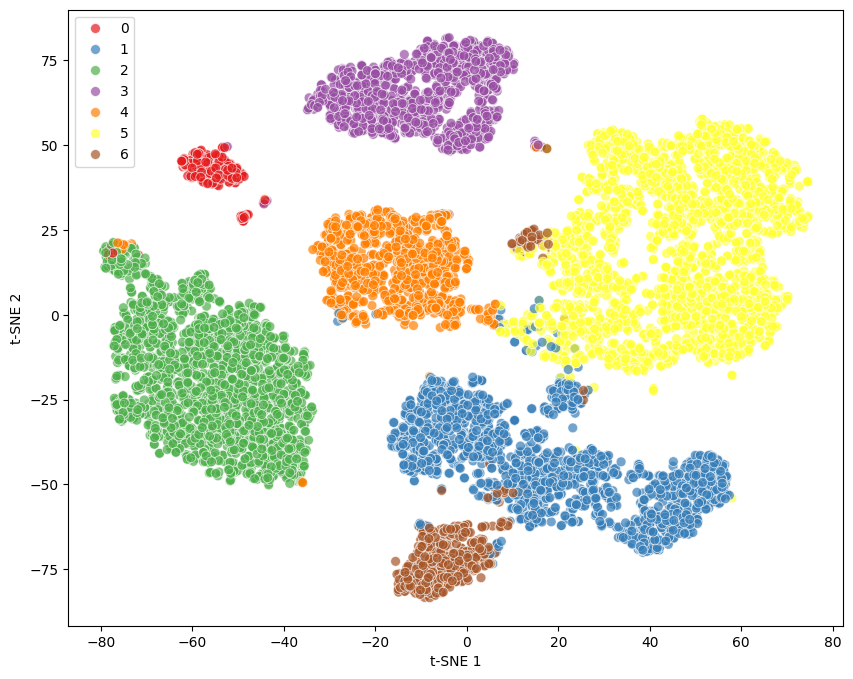

In [ ]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_train_tsne[:, 0], y=X_train_tsne[:, 1], hue=labels_subset, palette='Set1', s=50, alpha=0.7)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

In [ ]:
clustering = pd.DataFrame({'id_split': train['id_split'], 'cluster': train_labels, 'group': train['group']})

In [ ]:
counts = clustering.groupby(['id_split', 'cluster']).size().unstack(fill_value=0)
group_map = train.groupby('id_split')['group'].first()

normalized_counts = counts.div(counts.sum(axis=1), axis=0)
cluster_distribution = clustering.groupby(['cluster', 'group']).size().unstack(fill_value=0)  
norm_cluster_distribution = cluster_distribution.div(cluster_distribution.sum(axis=1), axis=0)

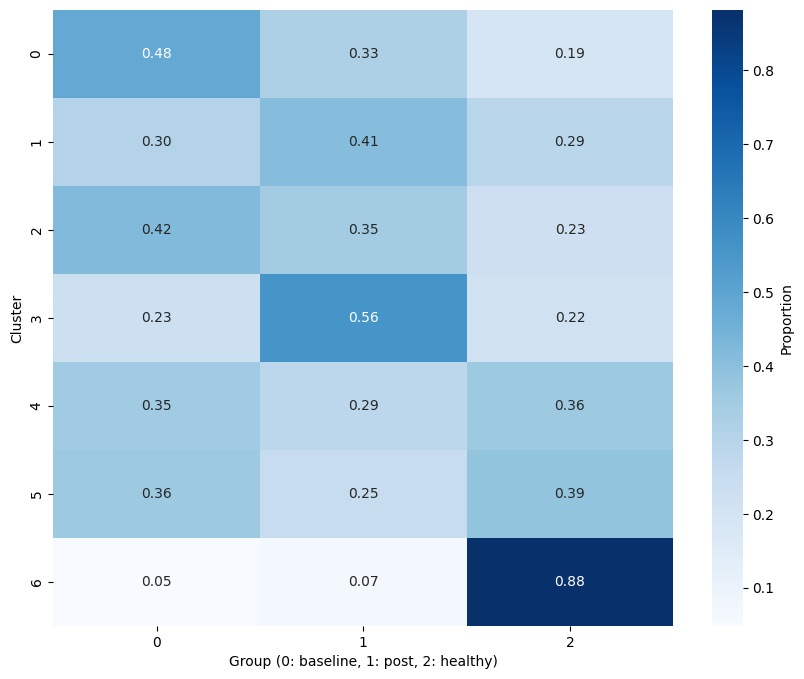

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(norm_cluster_distribution, cmap='Blues', annot=True, fmt='.2f', cbar_kws={'label': 'Proportion'}, xticklabels=['Baseline', 'Post', 'Healthy'], yticklabels=[f'Cluster {i}' for i in range(k)])
plt.xlabel('Group') 
plt.ylabel('Cluster')
plt.show()

In [ ]:
normalized_counts['group'] = normalized_counts.index.map(group_map)

X_feature = normalized_counts.drop(columns='group').values
y_feature = normalized_counts['group'].values

In [ ]:
decisiontree = DecisionTreeClassifier(random_state=seed)
decisiontree.fit(X_feature, y_feature)

DecisionTreeClassifier(random_state=42)

In [ ]:
test_clusters = kmeans.predict(X_test_pca)              
clust_test    = pd.DataFrame({'id_split': test['id_split'], 'cluster': test_clusters})  
counts_test   = clust_test.groupby(['id_split','cluster']).size().unstack(fill_value=0) 
normalized_counts_test = counts_test.div(counts_test.sum(axis=1), axis=0)                
test_group_map = test.groupby('id_split')['group'].first()                              
normalized_counts_test['group'] = normalized_counts_test.index.map(test_group_map)  

In [ ]:
X_test_feature = normalized_counts_test.drop(columns='group').values
y_test_feature = normalized_counts_test['group'].values

y_pred = decisiontree.predict(X_test_feature)
patient_accuracy = accuracy_score(y_test_feature, y_pred)
print(f'Patient accuracy: {patient_accuracy:.2f}')

Patient accuracy: 0.50


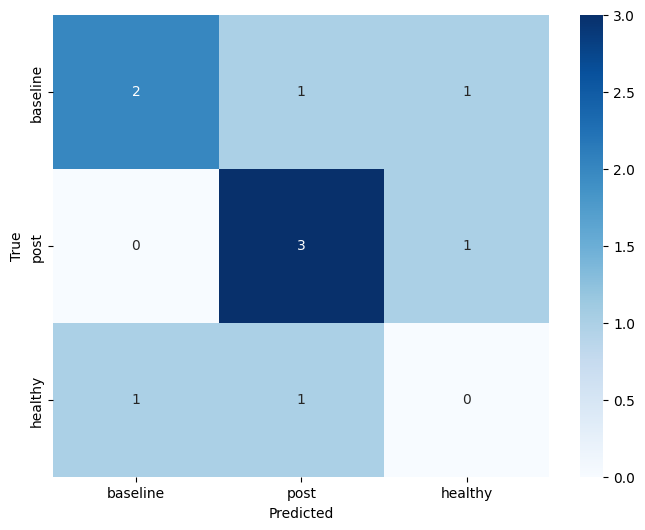

In [ ]:
group_labels = ['Baseline', 'Post', 'Healthy']
conf_matrix = confusion_matrix(y_test_feature, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=group_labels, yticklabels=group_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# lasso logistic regression
lr = LogisticRegression(penalty='l1', solver='liblinear', random_state=seed)
lr.fit(X_feature, y_feature)

In [ ]:
test_clusters = lr.predict(X_test_pca)         
clust_test = pd.DataFrame({'id_split': test['id_split'], 'cluster': test_clusters})
counts_test = clust_test.groupby(['id_split','cluster']).size().unstack(fill_value=0)
normalized_counts_test = counts_test.div(counts_test.sum(axis=1), axis=0)
test_group_map = test.groupby('id_split')['group'].first()
normalized_counts_test['group'] = normalized_counts_test.index.map(test_group_map)